# Working Paper

* [Overleaf Read-Only](https://www.overleaf.com/read/vyymkhwpyyqz#743fbf)

In [1]:
import os, zipfile
import pandas as pd

# Data Preparation

## Data Downloading

Download daily data of BTCUSDT, ETHUSDT and LTCUSDT from [Binance Data Collection](https://data.binance.vision/) with *[Command Line Tool](https://github.com/binance/binance-public-data)*

In [2]:
# !python binance-public-data/python/download-kline.py \
#     -t spot -s BTCUSDT BCHUSDT ETHUSDT LTCUSDT -skip-daily 1 \
#     -startDate 2008-01-01 -i 1d

In [3]:
# !unzip binance-public-data.zip -d / > /dev/null 2>&1

## Preprocessing

Merge from BTCUSDT, ETHUSDT, LTCUSDT, BCHUSDT to BTC-ETH, BTC-LTC, BTC-BCH

The trading pairs are selected based on the cryptocurrency cointegration research from Leung, T., & Nguyen, H. (2019)[^1]

[^1]: Leung, T., & Nguyen, H. (2019). Constructing cointegrated cryptocurrency portfolios for statistical arbitrage. Studies in Economics and Finance, 36(4), 581–599. https://doi.org/10.1108/SEF-08-2018-0264

In [4]:
klines_path = os.path.abspath(
    f'./binance-public-data/python/data/spot/monthly/klines/')
symbols = sorted([folder for folder in os.listdir(klines_path)])

dfs = []
for symbol in symbols:
    directory = os.path.join(klines_path, symbol, '1d')
    rawdfs = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.zip'):
            zip_file_path = os.path.join(directory, file_name)
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                # only one CSV file in each zip archive
                csv_file = zip_ref.namelist()[0]
                with zip_ref.open(csv_file) as csv_fp:
                    # Read the CSV data into a DataFrame
                    tempdf = pd.read_csv(csv_fp, header=None)
                    tempdf.columns = [
                        'open_time', 'open', 'high', 'low', 'close', 'volume',
                        'close_time', 'quote_asset_volume', 'number_of_trades',
                        'taker_buy_base_asset_volume',
                        'taker_buy_quote_asset_volume', 'ignore']
                    tempdf['tic'] = symbol
                    tempdf['close_time'] = pd.to_datetime(
                        tempdf['close_time'], unit='ms', utc=True
                        ).dt.normalize()
                    rawdfs.append(
                        tempdf[['close_time', 'close', 'quote_asset_volume',
                                'number_of_trades', 'tic']])

    rawdf = pd.concat(rawdfs, ignore_index=True)
    rawdf = rawdf.sort_values('close_time', ignore_index=True)
    dfs.append(rawdf)

print(f"The length of each df: {[len(df) for df in dfs]}")
dfs[2].tail()

The length of each df: [1647, 2480, 2480, 2362]


,close_time,close,quote_asset_volume,number_of_trades,tic
2475,2024-05-27 00:00:00+00:00,3894.22,1.424169e+09,971964,ETHUSDT
2476,2024-05-28 00:00:00+00:00,3844.69,1.605075e+09,941338,ETHUSDT
2477,2024-05-29 00:00:00+00:00,3767.43,1.274088e+09,883401,ETHUSDT
2478,2024-05-30 00:00:00+00:00,3747.91,1.042146e+09,765716,ETHUSDT
2479,2024-05-31 00:00:00+00:00,3762.29,1.032174e+09,680329,ETHUSDT


In [5]:
spreaddfs = [
    dfs[1][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']].merge(
        dfs[2][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']], on='close_time', suffixes=('_BTC', '_ETH')),
    dfs[1][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']].merge(
        dfs[3][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']], on='close_time', suffixes=('_BTC', '_LTC')),
    dfs[1][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']].merge(
        dfs[0][['close_time', 'close', 'quote_asset_volume', 'number_of_trades']], on='close_time', suffixes=('_BTC', '_BCH')),
]

print(f"The length of each spread: {[len(spreaddfs) for spreaddfs in spreaddfs]}")
spreaddfs[0].head()

The length of each spread: [2480, 2362, 1647]


,close_time,close_BTC,quote_asset_volume_BTC,number_of_trades_BTC,close_ETH,quote_asset_volume_ETH,number_of_trades_ETH
0,2017-08-17 00:00:00+00:00,4285.08,3.454770e+06,3427,302.00,2.154655e+06,4522
1,2017-08-18 00:00:00+00:00,4108.37,5.086958e+06,5233,293.96,2.858947e+06,5658
2,2017-08-19 00:00:00+00:00,4139.98,1.549484e+06,2153,290.91,6.200226e+05,1795
3,2017-08-20 00:00:00+00:00,4086.29,1.930364e+06,2321,299.10,7.428479e+05,2038
4,2017-08-21 00:00:00+00:00,4016.00,2.797232e+06,3972,323.29,1.689472e+06,3925


## Train Test Split

We set one year data as the test set, and all other data as the train set.

In [6]:
from datetime import datetime, timedelta

# Calculate the t as period count
spreaddfs = [df.assign(t=(df['close_time'] - df['close_time'].min()).dt.days) for df in spreaddfs]

test_date = [spreaddfs[i]['close_time'].iloc[-1] - timedelta(days=365) for i in range(len(spreaddfs))]
traindfs = [spreaddfs[i][spreaddfs[i]['close_time']<=test_date[i]] for i in range(len(spreaddfs))]
testdfs = [spreaddfs[i][spreaddfs[i]['close_time']>test_date[i]] for i in range(len(spreaddfs))]

print(f"The train set length is {[len(df) for df in traindfs]}")
print(f"The test set length is {[len(df) for df in testdfs]}")
traindfs[0].head()

The train set length is [2115, 1997, 1282]
The test set length is [365, 365, 365]


,close_time,close_BTC,quote_asset_volume_BTC,number_of_trades_BTC,close_ETH,quote_asset_volume_ETH,number_of_trades_ETH,t
0,2017-08-17 00:00:00+00:00,4285.08,3.454770e+06,3427,302.00,2.154655e+06,4522,0
1,2017-08-18 00:00:00+00:00,4108.37,5.086958e+06,5233,293.96,2.858947e+06,5658,1
2,2017-08-19 00:00:00+00:00,4139.98,1.549484e+06,2153,290.91,6.200226e+05,1795,2
3,2017-08-20 00:00:00+00:00,4086.29,1.930364e+06,2321,299.10,7.428479e+05,2038,3
4,2017-08-21 00:00:00+00:00,4016.00,2.797232e+06,3972,323.29,1.689472e+06,3925,4


## Spread

Co-integrated assets follow the equation from a research of Avellaneda[^1]:
    
\begin{equation}
    \ln\left(\frac{P_t}{P_{t_0}}\right) = \alpha(t-t_0) + \beta \ln\left(\frac{Q_t}{Q_{t_0}}\right) + X_t
\end{equation}

With the formula, we calculate the spread between BTC-ETH and BTC-LTC.

[^1]: Avellaneda, M., & Lee, J.-H. (2010). Statistical arbitrage in the US equities market. Quantitative Finance, 10(7), 761–782. https://econpapers.repec.org/article/tafquantf/v_3a10_3ay_3a2010_3ai_3a7_3ap_3a761-782.htm

In [7]:
import numpy as np

# BTC-ETH
traindfs[0] = traindfs[0].assign(
    ln_return_BTC=traindfs[0]['close_BTC'].pct_change().apply(lambda x: np.log(1 + x)),
    ln_return_ETH=traindfs[0]['close_ETH'].pct_change().apply(lambda x: np.log(1 + x))
).dropna()

# BTC-LTC
traindfs[1] = traindfs[1].assign(
    ln_return_BTC=traindfs[1]['close_BTC'].pct_change().apply(lambda x: np.log(1 + x)),
    ln_return_LTC=traindfs[1]['close_LTC'].pct_change().apply(lambda x: np.log(1 + x))
).dropna()

# BTC-BCH
traindfs[2] = traindfs[2].assign(
    ln_return_BTC=traindfs[2]['close_BTC'].pct_change().apply(lambda x: np.log(1 + x)),
    ln_return_BCH=traindfs[2]['close_BCH'].pct_change().apply(lambda x: np.log(1 + x))
).dropna()

In [8]:
import statsmodels.api as sm

# BTC-ETH
model_BE = sm.OLS(
    traindfs[0]['ln_return_BTC'],
    sm.add_constant(traindfs[0][['t', 'ln_return_ETH']]))
results_BE = model_BE.fit()

Xt_BE = results_BE.resid
traindfs[0] = traindfs[0].assign(Xt=Xt_BE)
print(results_BE.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_return_BTC   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1811.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:10:54   Log-Likelihood:                 4837.3
No. Observations:                2114   AIC:                            -9669.
Df Residuals:                    2111   BIC:                            -9652.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.332

In [9]:
# BTC-LTC
model_BL = sm.OLS(
    traindfs[1]['ln_return_BTC'],
    sm.add_constant(traindfs[1][['t', 'ln_return_LTC']]))
results_BL = model_BL.fit()

Xt_BL = results_BL.resid
traindfs[1] = traindfs[1].assign(Xt=Xt_BL)
print(results_BL.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_return_BTC   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1841.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:10:54   Log-Likelihood:                 4663.0
No. Observations:                1996   AIC:                            -9320.
Df Residuals:                    1993   BIC:                            -9303.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.781

In [10]:
# BTC-BCH
model_BB = sm.OLS(
    traindfs[2]['ln_return_BTC'],
    sm.add_constant(traindfs[2][['t', 'ln_return_BCH']]))
results_BB = model_BB.fit()

Xt_BB = results_BB.resid
traindfs[2] = traindfs[2].assign(Xt=Xt_BB)
print(results_BB.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_return_BTC   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1019.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):          2.19e-265
Time:                        12:10:54   Log-Likelihood:                 2981.4
No. Observations:                1281   AIC:                            -5957.
Df Residuals:                    1278   BIC:                            -5941.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.001      1.667

## Moving Window

We use the autocorrelation function (ACF) to determine the moving window size for \(\mu\) and \(\sigma\).
\begin{equation}
\text{ACF}(k) = \frac{\text{Cov}(Y_t, Y_{t+k})}{\text{Var}(Y_t)}
\end{equation}

In [11]:
threshold = 0.05 # A typical standard statistic threshold

_, _, pvalues_BE = sm.tsa.acf(traindfs[0]['Xt'], nlags=len(traindfs[0])-1, fft=False, qstat=True)
lag_length_BE = np.where(pvalues_BE > threshold)[0][0] + 1 # +1 because of the 0 indexing

print(f"The ideal Window Size for BTC-ETH under significant level of {threshold} is {lag_length_BE}")

_, _, pvalues_BL = sm.tsa.acf(traindfs[1]['Xt'], nlags=len(traindfs[1])-1, fft=False, qstat=True)
lag_length_BL = np.where(pvalues_BL > threshold)[0][0] + 1 # +1 because of the 0 indexing

print(f"The ideal Window Size for BTC-LTC under significant level of {threshold} is {lag_length_BL}")

_, _, pvalues_BB = sm.tsa.acf(traindfs[2]['Xt'], nlags=len(traindfs[2])-1, fft=False, qstat=True)
lag_length_BB = np.where(pvalues_BB > threshold)[0][0] + 1 # +1 because of the 0 indexing

print(f"The ideal Window Size for BTC-LTC under significant level of {threshold} is {lag_length_BB}")

The ideal Window Size for BTC-ETH under significant level of 0.05 is 263
The ideal Window Size for BTC-LTC under significant level of 0.05 is 1
The ideal Window Size for BTC-LTC under significant level of 0.05 is 1


# Spread Estimation

The process \(X_t\) follows the Ornstein-Uhlenbeck (OU) process:
\begin{equation}
dX_t = \theta (\mu - X_t) \, dt + \sigma \, dW_t
\end{equation}

where:
* $\theta$ is the rate of mean reversion,
* $\mu$ is the long-term mean of the process,
* $\sigma$ is the instantaneous volatility,
* $W_t$ is a Wiener process (or standard Brownian motion).

The solution to equation OU process using Itô's lemma is:
\begin{equation}
X_{t_1} = X_{t_0} e^{-\theta (t_1 - t_0)} + \mu \left(1 - e^{-\theta (t_1 - t_0)}\right) + \sigma \int_{t_0}^{t_1} e^{-\theta (t_1-t)} \, dW_t
\end{equation}

When estimating the spread, we can remove the randomness from our estimation:
\begin{equation}
X_{t_1} \approx X_{t_0} e^{-\theta (t_1 - t_0)} + \mu \left(1 - e^{-\theta (t_1 - t_0)}\right)
\end{equation}

Solving for $\theta$:

\begin{equation}
\theta = -\ln\left(\left|\frac{X_{t+1} - \mu}{X_{t} - \mu}\right|\right)
\end{equation}

In [12]:
traindfs[0] = traindfs[0].assign(
    mu=lambda x: x['Xt'].rolling(window=lag_length_BE, min_periods=1).mean(),
    Xt1=lambda x: x['Xt'].shift(-1),
    theta=lambda x: -np.log(np.abs((x['Xt1'] - x['mu']) / (x['Xt'] - x['mu'])))
)

traindfs[0].replace([np.inf, -np.inf], np.nan, inplace=True)
traindfs[0].dropna(subset=['theta'], inplace=True)

# Get std for the order of magnitude
X_std = traindfs[0]['Xt'].std()
stdev = traindfs[0]['theta'].std()

traindfs[0].drop(columns=['mu', 'Xt', 'Xt1', 'ln_return_BTC', 'ln_return_ETH'], inplace=True)

print(f"The std of theta is {stdev}")
traindfs[0].head()

The std of theta is 1.6599645947297927


,close_time,close_BTC,quote_asset_volume_BTC,number_of_trades_BTC,close_ETH,quote_asset_volume_ETH,number_of_trades_ETH,t,theta
2,2017-08-19 00:00:00+00:00,4139.98,1.549484e+06,2153,290.91,6.200226e+05,1795,2,-0.232403
3,2017-08-20 00:00:00+00:00,4086.29,1.930364e+06,2321,299.10,7.428479e+05,2038,3,-1.145503
4,2017-08-21 00:00:00+00:00,4016.00,2.797232e+06,3972,323.29,1.689472e+06,3925,4,-0.419127
5,2017-08-22 00:00:00+00:00,4040.00,3.752506e+06,6494,309.80,2.454426e+06,6577,5,0.805702
6,2017-08-23 00:00:00+00:00,4114.01,4.148686e+06,8629,315.74,2.753465e+06,8540,6,-0.917752


## RL Environment

In [15]:
# !pip install gymnasium > /dev/null 2>&1

In [16]:
import gymnasium as gym

class TradingEnv(gym.Env):
    def __init__(self, data, window_size, stdev=stdev, train=False):
        super(TradingEnv, self).__init__()
        self.data = data[['close_BTC', 'quote_asset_volume_BTC',
                          'number_of_trades_BTC', 'close_ETH',
                          'quote_asset_volume_ETH', 'number_of_trades_ETH',
                          't']].reset_index(drop=True)  # Ensure integer indexing

        self.train = train
        self.window_size = window_size

        self.n_steps = len(self.data)
        self.current_step = 0

        if train:
            self.theta = data['theta'].reset_index(drop=True)

        # Actions: estimate the theta
        self.action_space = gym.spaces.Box(
            low=-5*stdev, high=5*stdev, shape=(1,), dtype=np.float32)

        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, self.data.shape[1]), dtype=np.float32)

    def _next_observation(self):
        end = self.current_step + 1
        start = max(0, end - self.window_size)

        obs = self.data.iloc[start:end].values.astype(np.float32)
        # Pad zeros if current window size less than desired
        if end - start < self.window_size:
            padding = np.zeros(
                (self.window_size - (end-start), self.data.shape[1]),
                dtype=np.float32)
            obs = np.vstack((padding, obs))

        return obs

    def _get_reward(self, theta, theta_est):
        # Reward function
        reward = -np.abs(theta - theta_est)
        return reward

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)

        self.current_step = 0
        return self._next_observation(), {}

    def step(self, action):
        theta_est = action[0]
        if self.train:
            theta = self.theta[self.current_step]
            reward = self._get_reward(theta, theta_est)
        else:
            reward = 0

        self.current_step += 1
        done = self.current_step >= self.n_steps

        # zero-padded array if done
        if done:
            obs = np.zeros((self.window_size, self.data.shape[1]), dtype=np.float32)
        else:
            obs = self._next_observation()

        info = {'theta_est': theta_est} if not self.train else {}

        return obs, reward, done, False, info

In [17]:
# !pip install stable-baselines3 > /dev/null 2>&1

In [18]:
from stable_baselines3.common.env_checker import check_env

env_check = TradingEnv(traindfs[0], lag_length_BE)
check_env(env_check, warn=True)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## RL Prediction

# Trading

## Estimate the thetas

In [19]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DDPG
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

algorithms = {
    "PPO": PPO,
    "A2C": A2C,
    "SAC": SAC,
    "TD3": TD3,
    "DDPG": DDPG
}

env_train =  Monitor(TradingEnv(traindfs[0], window_size=lag_length_BE, train=True))
env_test = TradingEnv(testdfs[0], window_size=lag_length_BE, train=False)

theta_ests = {}
for name, algo in algorithms.items():
    print(f"Training {name}...")
    model = algo("MlpPolicy", env_train, verbose=0)
    model.learn(total_timesteps=10000)

    print(f"Evaluating {name} on test data...")
    # Reset the test environment
    env_test = Monitor(env_test)
    obs, _ = env_test.reset()
    done, thetas = False, []
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env_test.step(action)
        thetas.append(info['theta_est'])

    theta_ests[name] = thetas

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training PPO...
Evaluating PPO on test data...
Training A2C...
Evaluating A2C on test data...
Training SAC...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.74GB > 11.79GB
  warnings.warn(


Evaluating SAC on test data...
Training TD3...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.74GB > 11.61GB
  warnings.warn(


Evaluating TD3 on test data...
Training DDPG...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.74GB > 11.55GB
  warnings.warn(


Evaluating DDPG on test data...


## Calculate the spread

\begin{equation}
\hat{X_t} = \ln\left(\frac{P_t}{P_{t_0}}\right) - \alpha(t-t_0) - \beta \ln\left(\frac{Q_t}{Q_{t_0}}\right) - \text{const}
\end{equation}


In [20]:
testdfs[0] = testdfs[0].assign(
    ln_return_BTC=lambda x: x['close_BTC'].pct_change().apply(lambda pct: np.log(1 + pct)),
    ln_return_ETH=lambda x: x['close_ETH'].pct_change().apply(lambda pct: np.log(1 + pct))
)

testdfs[0].dropna(inplace=True)

testdfs[0] = testdfs[0].assign(
    Xt=lambda x: x['ln_return_BTC']
                  - results_BE.params['const']
                  - x['t'] * results_BE.params['t']
                  - x['ln_return_ETH'] * results_BE.params['ln_return_ETH'])

testdfs[0].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,close_time,close_BTC,quote_asset_volume_BTC,number_of_trades_BTC,close_ETH,quote_asset_volume_ETH,number_of_trades_ETH,t,ln_return_BTC,ln_return_ETH,Xt
2116,2023-06-03 00:00:00+00:00,27069.22,4.505887e+08,466520,1892.06,2.825504e+08,292512,2116,-0.006384,-0.007697,-0.000808
2117,2023-06-04 00:00:00+00:00,27115.21,5.237472e+08,504474,1890.01,3.281669e+08,289973,2117,0.001698,-0.001084,0.003141
2118,2023-06-05 00:00:00+00:00,25728.20,1.722666e+09,1420829,1810.50,1.017690e+09,688879,2118,-0.052507,-0.042979,-0.024876
2119,2023-06-06 00:00:00+00:00,27230.08,1.797636e+09,1345725,1884.64,9.076604e+08,616201,2119,0.056735,0.040134,0.032417
2120,2023-06-07 00:00:00+00:00,26339.34,1.589291e+09,1311928,1832.13,7.968567e+08,594071,2120,-0.033259,-0.028258,-0.014827


## Predict the next spread

Use the theta_est to estimate the next price.

\begin{equation}
X_{t_1} \approx X_{t_0} e^{-\theta (t_1 - t_0)} + \mu \left(1 - e^{-\theta (t_1 - t_0)}\right)
\end{equation}

Based on the estimation to make trading decisions.

In [21]:
Xt_est = {}
for name, algo in algorithms.items():
    testdfs[0] = testdfs[0].assign(
        mu=lambda x: x['Xt'].rolling(window=lag_length_BE, min_periods=1).mean(),
        theta=theta_ests[name][1:],
        Xt_est=lambda x: x['Xt']*np.exp(-x['theta']) + x['mu']*(1-np.exp(-x['theta']))
    )
    Xt_est[name] = testdfs[0]['Xt_est']

testdfs[0].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,close_time,close_BTC,quote_asset_volume_BTC,number_of_trades_BTC,close_ETH,quote_asset_volume_ETH,number_of_trades_ETH,t,ln_return_BTC,ln_return_ETH,Xt,mu,theta,Xt_est
2116,2023-06-03 00:00:00+00:00,27069.22,4.505887e+08,466520,1892.06,2.825504e+08,292512,2116,-0.006384,-0.007697,-0.000808,-0.000808,8.299823,-0.000808
2117,2023-06-04 00:00:00+00:00,27115.21,5.237472e+08,504474,1890.01,3.281669e+08,289973,2117,0.001698,-0.001084,0.003141,0.001167,-8.299823,7.945372
2118,2023-06-05 00:00:00+00:00,25728.20,1.722666e+09,1420829,1810.50,1.017690e+09,688879,2118,-0.052507,-0.042979,-0.024876,-0.007514,8.299823,-0.007518
2119,2023-06-06 00:00:00+00:00,27230.08,1.797636e+09,1345725,1884.64,9.076604e+08,616201,2119,0.056735,0.040134,0.032417,0.002469,8.299823,0.002476
2120,2023-06-07 00:00:00+00:00,26339.34,1.589291e+09,1311928,1832.13,7.968567e+08,594071,2120,-0.033259,-0.028258,-0.014827,-0.000990,-8.299823,-55.667580


## Mock Trading

* Long-position 1: long BTC short ETH
* Short-position -1: short BTC long ETH
* Close-position 0: hold nothing

When we estimate the spread will broaden up
- **action**: Long BTC and Short ETH

When we estimate the spread will close up
- **action**: Short BTC and Long ETH

In [22]:
import math

tc = 0.000
init_cash = 10000
portfolios = {}
X_mag = 3 * X_std
for name, algo in algorithms.items():

    cash = init_cash
    position = 0
    hold_btc, hold_eth = 0, 0
    portfolio = []

    testdfs[0] = testdfs[0].assign(Xt_est=Xt_est[name][1:])

    for i, row in testdfs[0].iterrows():
        if row['Xt_est'] > row['Xt']:
            if position == 0:
                weight = min((row['Xt_est']-row['Xt'])/X_mag, 1)
                hold_btc = cash / row['close_BTC'] * weight
                hold_eth = -cash / row['close_ETH'] * weight
                cash -= cash * tc * weight * 2
                position = 1
            elif position == -1:
                value_btc = hold_btc * row['close_BTC']
                value_eth = hold_eth * row['close_ETH']
                cash -= value_btc + value_eth
                cash -= value_btc * tc + value_eth * tc
                hold_btc, hold_eth = 0, 0
                position = 0
        elif row['Xt_est'] < row['Xt']:
            if position == 0:
                weight = min((row['Xt'] - row['Xt_est'])/X_mag, 1)
                hold_btc = -cash / row['close_BTC'] * weight
                hold_eth = cash / row['close_ETH'] * weight
                cash -= cash * tc * weight * 2
                position = -1
            elif position == 1:
                value_btc = hold_btc * row['close_BTC']
                value_eth = hold_eth * row['close_ETH']
                cash -= value_btc + value_eth
                cash -= value_btc * tc + value_eth * tc
                hold_btc, hold_eth = 0, 0
                position = 0

        portfolio_value = cash + hold_btc * row['close_BTC'] + hold_eth * row['close_ETH']

        portfolio.append({
                'date': row['close_time'],
                'cash': cash,
                'hold_btc': hold_btc,
                'hold_eth': hold_eth,
                'position': position,
                'portfolio': portfolio_value
            })

        if portfolio_value < 0:
            break

    portfolios[name] = portfolio

    print(f"{name} made {(cash/init_cash-1)*100:.2f}% profit")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PPO made -0.40% profit
A2C made -0.35% profit
SAC made 3.19% profit
TD3 made -27.16% profit
DDPG made -19.55% profit


# Results

In [29]:
df_ports = {name: pd.DataFrame(portfolio) for name, portfolio in portfolios.items()}

df_ports['DDPG'].head()

5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,cash,hold_btc,hold_eth,position,portfolio
0,2023-06-03 00:00:00+00:00,10000.000000,0.000000,0.000000,0,10000.000000
1,2023-06-04 00:00:00+00:00,10000.000000,0.368797,-5.290977,1,10000.000000
2,2023-06-05 00:00:00+00:00,10000.000000,0.368797,-5.290977,1,9909.160892
3,2023-06-06 00:00:00+00:00,9929.223775,0.000000,0.000000,0,9929.223775
4,2023-06-07 00:00:00+00:00,9929.223775,-0.376973,5.419497,-1,9929.223775


In [39]:
rf = 0.06
trade_d = 365

stats = {}
for name, df_port in df_ports.items():
    df_port['returns'] = df_port['portfolio'].pct_change()
    daily_std = df_port['returns'].std()
    avg_daily_return = df_port['returns'].mean()
    annual_return = avg_daily_return * trade_d
    annual_std = daily_std * (trade_d ** 0.5)
    sharpe_ratio = (annual_return - rf) / annual_std

    stats[name] = {
        'std': daily_std,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio
    }

for name, stat in stats.items():
    print(f"{name}: Std = {stat['std']*100:.2f}%, Annual Return = {stat['annual_return']*100:.2f}%, Sharpe Ratio = {stat['sharpe_ratio']:.2f}")

PPO: Std = 0.05%, Annual Return = -0.40%, Sharpe Ratio = -6.68
A2C: Std = 0.08%, Annual Return = -0.34%, Sharpe Ratio = -4.11
SAC: Std = 2.61%, Annual Return = 16.86%, Sharpe Ratio = 0.22
TD3: Std = 2.34%, Annual Return = -20.41%, Sharpe Ratio = -0.59
DDPG: Std = 2.81%, Annual Return = -6.06%, Sharpe Ratio = -0.22


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


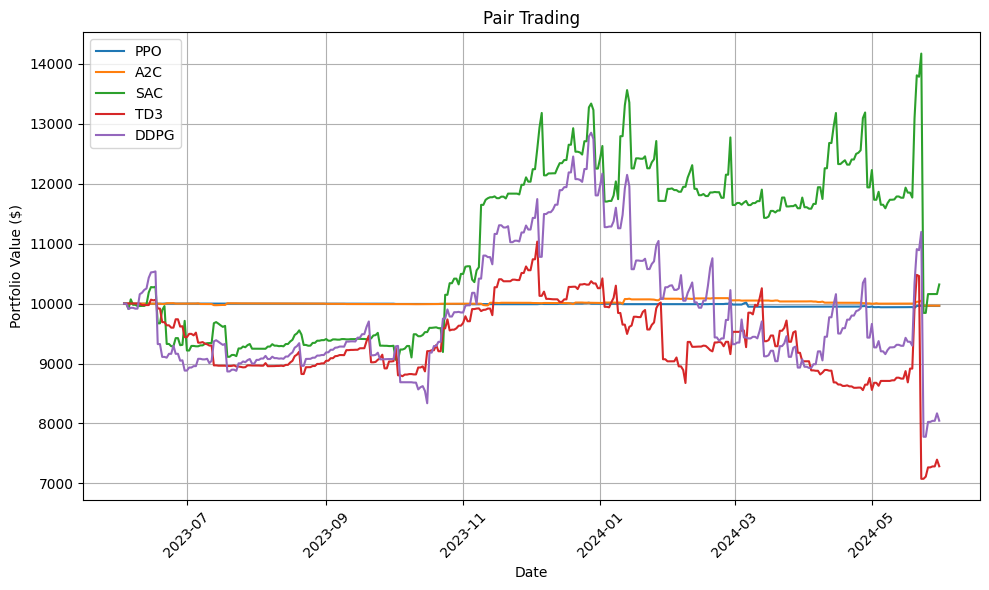

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, df_port in df_ports.items():
    plt.plot(df_port['date'], df_port['portfolio'], label=name)

plt.title('Pair Trading')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()